# Linear Discriminant Analysis as a dimensionality reduction technique -- Solution

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
%matplotlib notebook
np.set_printoptions(precision=3, suppress=True)


***
## Activity Question 1 (C)
***

In [2]:
mu_0 = np.array([3,3.67]).reshape((2,1))
mu_1 = np.array([4.67,2]).reshape((2,1))
w_a = np.array([-10,1]).reshape((2,1))
w_b = np.array([-1.1,1]).reshape((2,1))
w_c = np.array([0.2,1]).reshape((2,1))
w_d = np.array([0.9,1]).reshape((2,1))
S = np.array([[15.33,9],[9,13.2]])
J_a = (w_a.T @(mu_0 - mu_1))**2 / (w_a.T@S@w_a)
J_b = (w_b.T @(mu_0 - mu_1))**2 / (w_b.T@S@w_b)
J_c = (w_c.T @(mu_0 - mu_1))**2 / (w_c.T@S@w_c)
J_d = (w_d.T @(mu_0 - mu_1))**2 / (w_d.T@S@w_d)
print("J_a:", J_a)
print("J_b:", J_b)
print("J_c:", J_c)
print("J_d:", J_d)

J_a: [[0.247]]
J_b: [[1.029]]
J_c: [[0.103]]
J_d: [[0.001]]


***
## Activity Question 2
***

### Step 0: prepare the data

In [3]:
# Generate data. The "random_state" was set to 2 for easy replication 
x_p2, y_p2 = datasets.make_classification(n_samples=150, n_features=3, n_informative=2, n_redundant=0, 
                                          n_repeated=0, n_classes=3, n_clusters_per_class=1, weights=None, 
                                          class_sep=2, random_state=2, scale = 1)

<IPython.core.display.Javascript object>


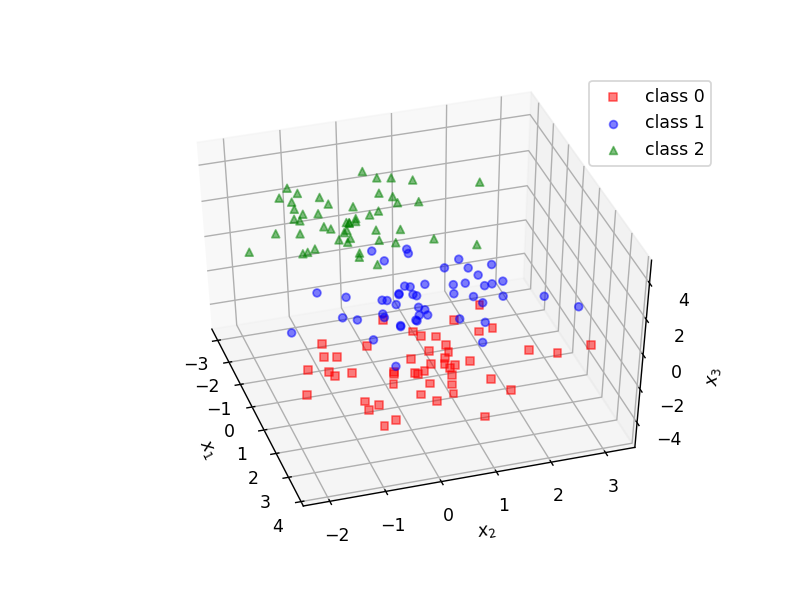

In [4]:
# Visualize the generated data
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_p2[:,0][y_p2 == 0], ys=x_p2[:,1][y_p2 == 0], zs=x_p2[:,2][y_p2 == 0],  
           marker='s', color='red', alpha=0.5, label="class 0")
ax.scatter(xs=x_p2[:,0][y_p2 == 1], ys=x_p2[:,1][y_p2 == 1], zs=x_p2[:,2][y_p2 == 1],  
           marker='o', color='blue', alpha=0.5, label="class 1")
ax.scatter(xs=x_p2[:,0][y_p2 == 2], ys=x_p2[:,1][y_p2 == 2], zs=x_p2[:,2][y_p2 == 2],  
           marker='^', color='green', alpha=0.5, label="class 2")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.legend()
plt.show()

In [5]:
# Split the data according to different classes. 
# note that the classes are {0,1,2}, not {1,2,3}
x_p2_c0 = x_p2[:,:][y_p2 == 0]
x_p2_c1 = x_p2[:,:][y_p2 == 1]
x_p2_c2 = x_p2[:,:][y_p2 == 2]

### Step 1: calculate the mean of the each class

In [6]:
# Calculate the mean of each class and all data.
mu_c0 = np.mean(x_p2_c0,axis=0)
mu_c1 = np.mean(x_p2_c1,axis=0)
mu_c2 = np.mean(x_p2_c2,axis=0)
mu = np.mean(x_p2, axis=0)
# Number of data points in each class
n_0 = x_p2_c0.shape[0]
n_1 = x_p2_c1.shape[0]
n_2 = x_p2_c2.shape[0]

In [7]:
print("Mean of class 0 is",mu_c0, "\nMean of class 1 is", mu_c1, "\nMean of class 2 is", mu_c2, "\nMean of all data", mu)

Mean of class 0 is [ 2.058  0.184 -1.759] 
Mean of class 1 is [1.86  0.3   1.868] 
Mean of class 2 is [-1.858 -0.172  1.844] 
Mean of all data [0.687 0.104 0.651]


### Step 2: Calculate the Between-Class Variance matrix $S_B$.

Recall that the formula to calculate $S_B$ is:
$$S_{B} = \sum_{j=0}^{k-1}n_j(\vec{\mu_j}-\vec{\mu})(\vec{\mu_j}-\vec{\mu})^T$$

In [8]:
# First calculate S_B_j for each class. Then add together
# Hint: use reshape((m,1)) to convert a 1-dimensional numpy array to a 2-dimensional numpy array of shape (m,1)
S_B_0 = (mu_c0 - mu).reshape((3,1)) @ (mu_c0 - mu).reshape((1,3))
S_B_1 = (mu_c1 - mu).reshape((3,1)) @ (mu_c1 - mu).reshape((1,3))
S_B_2 = (mu_c2 - mu).reshape((3,1)) @ (mu_c2 - mu).reshape((1,3))
S_B = n_0 * S_B_0 + n_1 * S_B_1 + n_2 * S_B_2

In [9]:
S_B

array([[ 486.503,   52.081, -245.643],
       [  52.081,    6.048,  -14.158],
       [-245.643,  -14.158,  435.663]])

### Step 3: Calculate the Within-Class Variance matrix $S_W$

Recall that the formula to calculate $S_W$ is:
$$S_{W_j} = \sum_{\vec{x}^{(i)} \in C_j}(\vec{x}^{(i)}-\vec{\mu_j})(\vec{x}^{(i)}-\vec{\mu_j})^T,\ j=0,1,2$$
$$S_W = \sum_{j = 0}^{2}S_{W_j}$$

In [10]:
# Calculate S_W_j for each class j. S_W is the sum of all S_W_j
S_W_0 = (x_p2_c0 - mu_c0).T@(x_p2_c0 - mu_c0)
S_W_1 = (x_p2_c1 - mu_c1).T@(x_p2_c1 - mu_c1)
S_W_2 = (x_p2_c2 - mu_c2).T@(x_p2_c2 - mu_c2)
S_W = S_W_0 + S_W_1 + S_W_2

In [11]:
S_W

array([[ 83.355,  -1.695,   4.545],
       [ -1.695, 142.149,  -9.89 ],
       [  4.545,  -9.89 , 149.036]])

### Step 4:  Find the eigenvectors and eigenvalues of matrix $S_W^{-1}S_B$

In [12]:
W = np.linalg.inv(S_W)@S_B
eig_vals, eig_vecs = np.linalg.eig(W)

In [13]:
eig_vecs

array([[ 0.92 ,  0.573, -0.126],
       [ 0.036,  0.142,  0.991],
       [-0.391,  0.807, -0.039]])

In [14]:
eig_vals

array([7.288, 1.719, 0.   ])

### Step 5: Sort the eigenvectors by decreasing eigenvalues, and select top $r$ eigenvectors to construct a $r$-dimensional subspace

In [16]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k:k[0], reverse=True)

In [17]:
for i in range(len(eig_pairs)):
    print("Eigenvalue:",eig_pairs[i][0].round(3), "; the corresponding eigenvector:", eig_pairs[i][1], "\n")

Eigenvalue: 7.288 ; the corresponding eigenvector: [ 0.92   0.036 -0.391] 

Eigenvalue: 1.719 ; the corresponding eigenvector: [0.573 0.142 0.807] 

Eigenvalue: 0.0 ; the corresponding eigenvector: [-0.126  0.991 -0.039] 



##### The best 1-dimensional subspace is the first eigenvector after sort, and the best 2-dimensional subspace the span of the first two eigenvectors.

### Step 6: Transform the data points onto the new subspace.

There is no code to fill in in this step. Use the plotting code given to confirm that the LDA gives the best low-dimensional subspace for class separation.

In [18]:
%matplotlib inline
def visualize_1D_linear_discriminant(ld1, y, n_class, color=["red", "blue", "green"], marker=["s","o","^"]):
    for i in range(n_class):
        plt.scatter(ld1[y == i], np.zeros_like(ld1[y == i]), marker=marker[i], color=color[i], alpha=0.5, label="class {0}".format(i))
        mean = np.mean(ld1[y == i])
        std = np.std(ld1[y == i])
        a = np.linspace(mean - 3*std, mean + 3*std, 100)
        plt.plot(a, stats.norm.pdf(a, mean, std), color = color[i])
        plt.scatter(mean, 0, color="black", marker=marker[i], s=90, label="m_{0}".format(i))
    plt.legend()
    plt.show()
    plt.close()
    
def visualize_2D_linear_discriminants(ld1, y, n_class, color=["red", "blue", "green"], marker=["s","o","^"]):
    for i in range(n_class):
        plt.scatter(ld1[:,0][y == i], ld1[:,1][y == i], marker=marker[i], color=color[i], alpha=0.5, label="class {0}".format(i))
        mean = np.mean(ld1[y == i], axis = 0)
        plt.scatter(mean[0], mean[1], color="black", marker=marker[i], s=70, label="m_{0}".format(i))
    mean = np.mean(ld1, axis = 0)
    plt.scatter(mean[0], mean[1], color="black", marker="x", s=70, label="m")
    plt.legend()
    plt.show()
    plt.close()

### 1 dimensional:

The following code visualize the distribution of the data when projected onto different 1-dimensional subspaces. Apart from the data points, we have also plotted the mean of each class after projection, and a normal distribution curve using each class's mean and variance after projection. 

By comparing different plots, you may get a sense that when data are projected onto subspaces constructed using LDA, they are more separated ("high difference in mean and low variances in each class"). Be cautious that the scale of the x-axis may change. 

#### Project on the first eigenvector

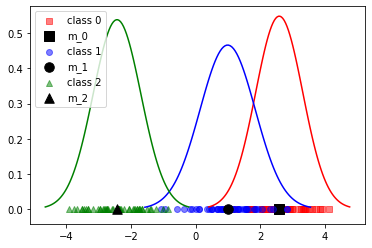

In [19]:
w_best = eig_pairs[0][1].reshape((3,1))
x_p2_best_1d = x_p2@w_best
visualize_1D_linear_discriminant(x_p2_best_1d, y_p2,3)

#### Project on the second eigenvector

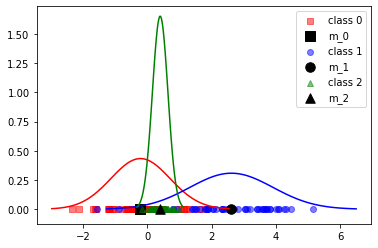

In [20]:
w_second = eig_pairs[1][1].reshape((3,1))
x_p2_second_1d = x_p2@w_second
x_p2_second_1d
visualize_1D_linear_discriminant(x_p2_second_1d, y_p2,3)

#### Project on a arbitrary eigenvector

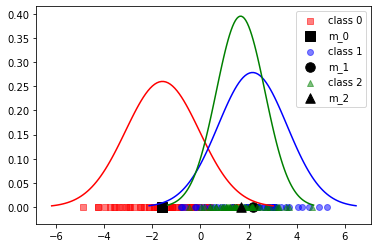

In [21]:
# An arbitrary vector w_arbi. You can change this vector and explore. 
# ** Cautious: the scale of the x-axis may change **
w_arbi = np.array([[0],[1],[1]])
x_p2_arbi_1d = x_p2@w_arbi
visualize_1D_linear_discriminant(x_p2_arbi_1d, y_p2,3)

### 2 dimensional:

The following code visualize the distribution of the data when projected onto different 2-dimensional subspaces. We have also plotted the mean of each class after projection. We did not construct a multi-variate Gaussian distribution as in the 1-dimensional case, but the variance of each class can be captured by "how tight the clusters of the classes are".   

Be cautious that the scale of the x-axis and y-axis may change. 

#### Project on the span of first two eigenvectors

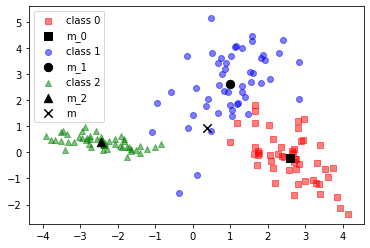

In [22]:
W_best_2d = np.hstack((eig_pairs[0][1].reshape((3,1)), eig_pairs[1][1].reshape((3,1))))
x_p2_best_2d = x_p2@W_best_2d
visualize_2D_linear_discriminants(x_p2_best_2d, y_p2, 3)

#### Project on the span of two arbitrary linearly independent vectors

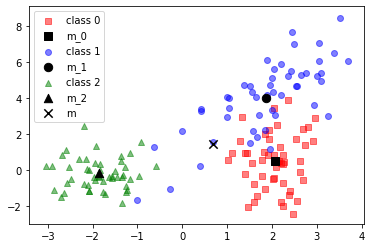

In [23]:
# An arbitrary matrix W_arbi_2d. You can change this vector and explore. 
# ** Cautious: the scale of the x-axis and y-axis may change **
W_arbi_2d = np.array([[1,1],[0,1],[0,1]])
x_p2_arbi_2d = x_p2@W_arbi_2d
visualize_2D_linear_discriminants(x_p2_arbi_2d, y_p2, 3)

### Congratulations on finishing Activity 2. Hope you now understand how to implement multi-class LDA and get a sense of how it select linear discriminants. By far you have completed the majority of this tutorial. There is one more simple activity that compare LDA and PCA as dimensionality reduction techniques. Hope you will enjoy it.

***
## Activity 3 
***

### Set Up

In [24]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris.data
y = iris.target
x_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
klass = iris.target_names
X.shape, y.shape

((150, 4), (150,))

In [25]:
label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)
print(xtrain.shape)

xtrain_normalized = normalize(xtrain, norm='l2', axis=0)
xtest_normalized = normalize(xtest, norm='l2', axis=0)

(112, 4)


In [41]:
%matplotlib inline
def plot2d(X, y, xlab='PC1', ylab='PC2', title='PCA: first 2 principal components'):
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label],
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label] )
        mean = np.mean(X[:,:][y == label], axis = 0)
        plt.scatter(x=mean[0],y=mean[1],
                    marker=marker,
                    color="black",
                    s=80,
                    alpha=1)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    leg = plt.legend(loc=0, fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

In [42]:
def evaluate_model(model, xtrain, ytrain, xtest, ytest, model_name):
    pred_train = model.predict(xtrain)
    err_train = np.mean(pred_train != ytrain)
    print("The error rate for training set using {:} (r=2) is {:.3f}%".format(model_name, err_train*100))
    
    pred_test = model.predict(xtest)
    err_test = np.mean(pred_test != ytest)
    print("The error rate for test set using {:} (r=2) is {:.3f}%".format(model_name, err_test*100))

### Method 1: Two Most Significant Features

We find the most significant features by directly do linear regression on the dataset, and pick the two features with greatest absolute weight. 

*Note* that this is not a good way of selecting features in the sense for classification tasks, since 1) the selected features are important for regression but ignores the labels; 2) the select features are original features, whereas PCA and LDA are able to combine different features to form new features; and 3) the select features may be correlated, where as PCA and LDA provides orthogonal features.

We just want to include this crude method to give you a sense of dimensionality reduction.

In [45]:
w = np.linalg.inv(xtrain.T@xtrain)@xtrain.T@ytrain
w

array([-0.16 ,  0.051,  0.329,  0.463])

The last two features are the most significant

In [49]:
xtrain_truncated = xtrain[:, 2:]
xtest_truncated = xtest[:, 2:]
print(xtrain_truncated.shape)

(112, 2)


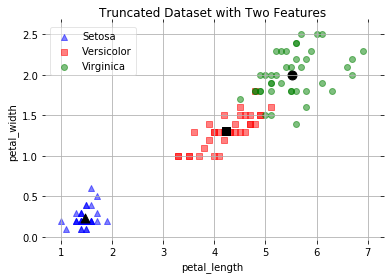

In [50]:
plot2d(xtrain_truncated, ytrain, x_columns[2], x_columns[3], 'Truncated Dataset with Two Features')

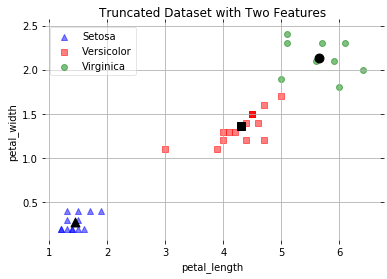

In [51]:
plot2d(xtest_truncated, ytest, x_columns[2], x_columns[3], 'Truncated Dataset with Two Features')

In [53]:
lr_truncated = LogisticRegression(solver='liblinear', multi_class='auto')
lr_truncated.fit(xtrain_truncated, ytrain)
evaluate_model(lr_truncated, xtrain_truncated, ytrain, xtest_truncated, ytest, "Truncated X")

The error rate for training set using Truncated X (r=2) is 20.536%
The error rate for test set using Truncated X (r=2) is 31.579%


### Method 2: PCA

We use PCA to form two most important features.

In [54]:
pca = PCA(n_components=2)
xtrain_pca = pca.fit_transform(xtrain_normalized)
xtest_pca = pca.transform(xtest_normalized)

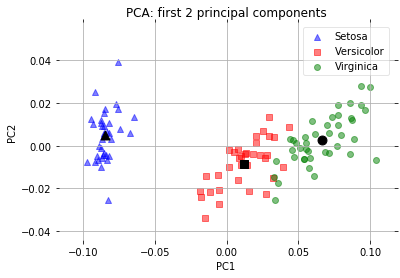

In [55]:
plot2d(xtrain_pca, ytrain)

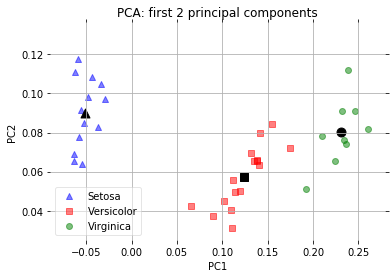

In [56]:
plot2d(xtest_pca, ytest)

In [57]:
lr_pca = LogisticRegression(solver='liblinear', multi_class='auto')
lr_pca.fit(xtrain_pca, ytrain)
evaluate_model(lr_pca, xtrain_pca, ytrain, xtest_pca, ytest, "PCA")

The error rate for training set using PCA (r=2) is 30.357%
The error rate for test set using PCA (r=2) is 42.105%


### Method 3: LDA

We use LDA to form two most important features.

In [58]:
lda2 = LinearDiscriminantAnalysis(n_components=2, store_covariance=True)
xtrain_lda2 = lda2.fit_transform(xtrain_normalized, ytrain)
xtest_lda2 = lda2.fit_transform(xtest_normalized, ytest)

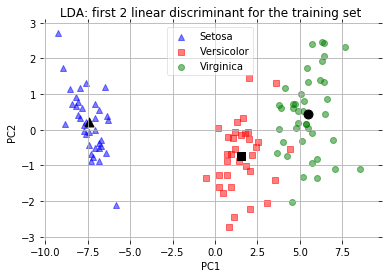

In [59]:
plot2d(xtrain_lda2, ytrain, title='LDA: first 2 linear discriminant for the training set')

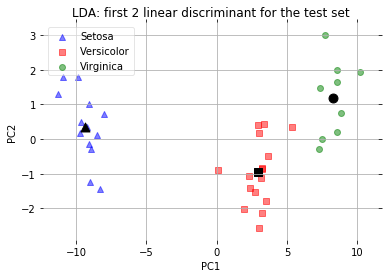

In [60]:
plot2d(xtest_lda2, ytest, title='LDA: first 2 linear discriminant for the test set')

In [62]:
lr_lda = LogisticRegression(solver='liblinear', multi_class='auto')
lr_lda.fit(xtrain_lda2, ytrain)
evaluate_model(lr_lda, xtrain_lda2, ytrain, xtest_lda2, ytest, "LDA")

The error rate for training set using LDA (r=2) is 4.464%
The error rate for test set using LDA (r=2) is 13.158%


#### Note the different performance of each dimensionality reduction method on a classification task. Note that different data or classfication algorithm will may give you different results, but the main take-away here is that when you have high-dimensional data for a classification task, probably you want to use LDA to pre-process the data. 

### Congratulations on finishing Activity 3!

## Reference
- https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html